In [3]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate, remove_bad_data, chi2_analysis
import pandas as pd
import numpy as np
# from tqdm import tqdm
print(pp.__version__)
import matplotlib.pyplot as plt
import ruptures as rpt
from tqdm import tqdm
# from julia.PowerModels import run_ac_opf
# from julia.PowerModels import run_ac_opf

2.0.1


In [4]:
def create_measurement_unit(df_measurement, net):
    list_value=[]
    list_std=[]
    for index, row in df_measurement.iterrows():
        if row['element_type'] =='bus':
            if row['meas_type'] =='v':
                mu= net.res_bus.iloc[row['element'],0]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='p':
                mu= net.res_bus.iloc[row['element'],2]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
            elif row['meas_type'] =='q':
                mu= net.res_bus.iloc[row['element'],3]
                sigma = (abs(mu)*upper_bus_accuracy-abs(mu)*lower_bus_accuracy)/4
                
        elif row['element_type'] =='line':
            if row['side']=='from':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='p':
                    mu= net.res_line.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type'] =='q':
                    mu = net.res_line.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                elif row['meas_type']=='i':
                    mu=net.res_line.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_line_accuracy-abs(mu)*lower_line_accuracy)/4
                    
                    
        elif row['element_type'] =='trafo':
            if row['side']=='from':
                if row['meas_type'] == 'i':
                    mu =net.res_trafo.iloc[row['element'],6]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'p':
                    mu =net.res_trafo.iloc[row['element'],0]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] == 'q':
                    mu =net.res_trafo.iloc[row['element'],1]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
            elif row['side']=='to':
                if row['meas_type'] =='i':
                    mu =net.res_trafo.iloc[row['element'],7]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='p':
                    mu =net.res_trafo.iloc[row['element'],2]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
                elif row['meas_type'] =='q':
                    mu =net.res_trafo.iloc[row['element'],3]
                    sigma = (abs(mu)*upper_trafo_accuracy-abs(mu)*lower_trafo_accuracy)/4
#         print(mu)  
        value = np.random.normal(mu, sigma, 1)
        list_value.append(value[0])
        list_std.append(sigma)
    df_measurement['value']=list_value
    df_measurement['std_dev']=list_std

    for index, row in df_measurement.iterrows():
        if row['element_type']=='bus':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'])
        elif row['element_type']=='line':
            pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                  std_dev=row['std_dev'], element=row['element'], side=row['side'])
        elif row['element_type']=='trafo':
            if row['meas_type'] in ['p','q']:
                pp.create_measurement(net, row['meas_type'], row['element_type'], value=row['value'], 
                                      std_dev=row['std_dev'], element=row['element'], side=row['side'])
    return df_measurement, net

In [5]:
global upper_bus_accuracy, lower_bus_accuracy, upper_line_accuracy, lower_line_accuracy, upper_trafo_accuracy, lower_trafo_accuracy
upper_bus_accuracy=1.01
lower_bus_accuracy=0.99
upper_line_accuracy=1.03
lower_line_accuracy=0.97
upper_trafo_accuracy=1.03
lower_trafo_accuracy=0.97

In [6]:
#modelling duck curve pattern for solar PV generation
scaling_for_solar=np.array([0,0,0,0,0,0,0.02,0.1,0.3,0.5,0.7,0.8,0.8,1.0,1.0,0.8,0.7,0.4,0.2,0,0,0,0,0,0])
# scaling_for_solar=np.array([np.random.normal(item, 0.01, 60) if item !=0 else np.zeros(60) for item in scaling_for_solar])
scaling_for_solar=np.array([np.random.normal(item, 0.05, 1)[0] if item !=0 else np.zeros(1)[0] for ind in range(len(scaling_for_solar)-1) for item in np.linspace(scaling_for_solar[ind], scaling_for_solar[ind+1],60)])
scaling_for_solar=np.array([value if value >0 else np.zeros(1)[0] for value in scaling_for_solar])
scaling_for_solar.shape=(1,24*60)
scaling_for_load=np.array([0.3,0.2,0.15,0.15, 0.2,0.25,
                          0.4,0.5,0.6,0.7,0.4,0.5,0.6,
                          0.7,0.65,0.55,0.55,0.6,0.7,
                          0.8,0.86,0.9,0.5,0.3])
scaling_for_load=np.array([[np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15),
                            np.random.normal(item, 0.1, 15)] for item in scaling_for_load])
scaling_for_load.shape=(1,24*60)

In [7]:
scaling_for_solar[0][800:805]=0.1
scaling_for_solar[0][705:710]=0.1
scaling_for_solar[0][677:682]=0.1

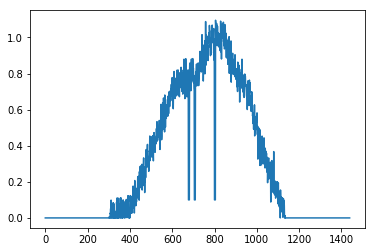

In [8]:
fig, ax = plt.subplots()

ax.plot(range(len(scaling_for_solar[0])), scaling_for_solar[0])
plt.show()





round:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1]
0    0.036
1    0.027
Name: p_mw, dtype: float64


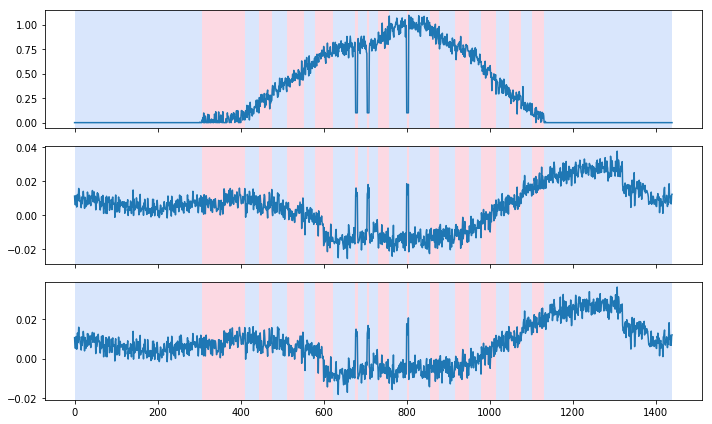





round:  33%|███▎      | 1/3 [03:04<06:08, 184.01s/it]

bus : 2 has solar PV size:  [-0.06010852662282935]
bus : 2 has solar PV size:  [0.05596953966469862]
bus : 2 has solar PV size:  [0.040074974292322256]
bus : 3 has solar PV size:  [-0.06010852662282935, -0.052317334412933944]
bus : 3 has solar PV size:  [0.05596953966469862, 0.04644457549062817]
bus : 3 has solar PV size:  [0.040074974292322256, 0.030654579518374605]
[1 1]
0    0.043
1    0.026
Name: p_mw, dtype: float64


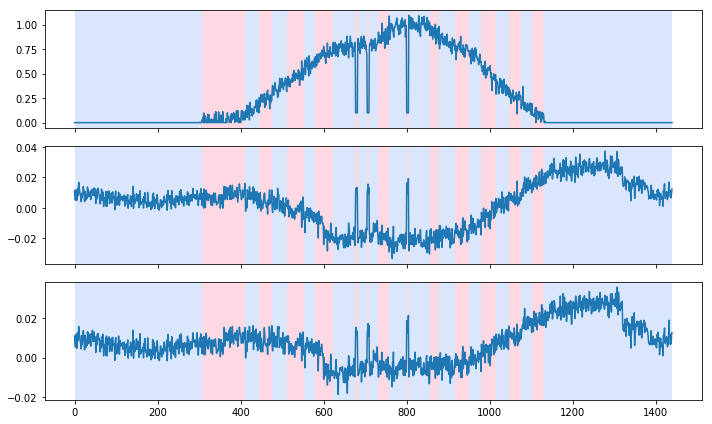





round:  67%|██████▋   | 2/3 [06:05<03:03, 183.31s/it]

bus : 2 has solar PV size:  [-0.06872530554063598]
bus : 2 has solar PV size:  [0.0653848874914105]
bus : 2 has solar PV size:  [0.04907849636560327]
bus : 3 has solar PV size:  [-0.06872530554063598, -0.0510699073717733]
bus : 3 has solar PV size:  [0.0653848874914105, 0.04491858828466481]
bus : 3 has solar PV size:  [0.04907849636560327, 0.02986009068882356]
[1 1]
0    0.021
1    0.010
Name: p_mw, dtype: float64


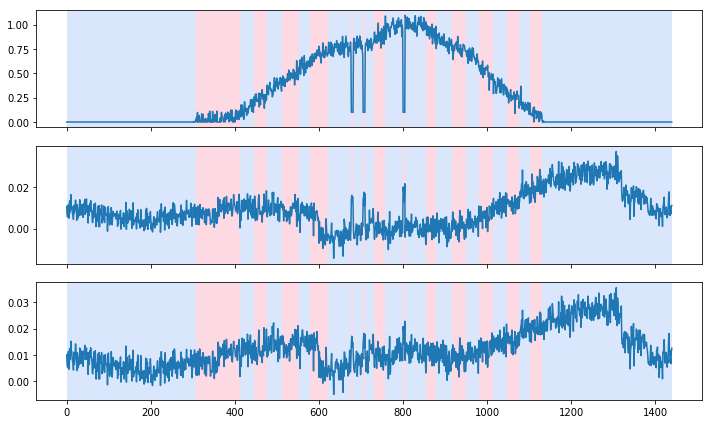





round: 100%|██████████| 3/3 [09:14<00:00, 185.03s/it]

bus : 2 has solar PV size:  [-0.04990784856112125]
bus : 2 has solar PV size:  [0.041230306065450736]
bus : 2 has solar PV size:  [0.02705594243245156]
bus : 3 has solar PV size:  [-0.04990784856112125, -0.034966882456024063]
bus : 3 has solar PV size:  [0.041230306065450736, 0.020187566779404503]
bus : 3 has solar PV size:  [0.02705594243245156, 0.01003031288211562]


In [60]:
list_PV_loc=[]
list_PV_value=[]
list_PV_detected_loc=[]
list_PV_detected_value_1=[]
list_PV_detected_value_2=[]
list_PV_detected_value_3=[]


for round in tqdm(range(3), desc='round: '):
    p_mw=np.array([[0,0,0,0]])
    
    pv_location=np.zeros(2, dtype='int')
    while sum(pv_location) == 0:
        pv_location=np.random.randint(2, size=2) 
#     pv_location=np.array([1,1])
    print(pv_location)#     
    list_PV_loc.append(pv_location)
    net = pn.simple_four_bus_system()
    net.sgen.p_mw=np.random.randint(50, size=2)/1000
    list_PV_value.append(np.array(net.sgen.p_mw[:]))
    print(net.sgen.p_mw)
    net.sgen.q_mvar[:]=0
    for scaling_solar, load_scaling in zip(scaling_for_solar[0],scaling_for_load[0]):
        net.sgen.scaling=[scaling_solar*pv_location[0], scaling_solar*pv_location[1]]
        net.load.scaling=[load_scaling, load_scaling]
        pp.runpp(net)
        df_measurement=pd.DataFrame()
        df_measurement['meas_type']=['v','v','p','p','q','q','i','i']
        df_measurement['element_type']=['bus','bus','line','line','line','line','line','line']
        df_measurement['element']=[2,3,0,1,0,1,0,1]
        df_measurement['side']=['None','None','from','from','from','from','from','from']
        df_measurement, net = create_measurement_unit(df_measurement, net)
        success = estimate(net, init="slack", calculate_voltage_angles=True, zero_injection=[1])
        new_mw=np.array([[item for item in net.res_bus_est.p_mw[:]]])
        p_mw=np.concatenate((p_mw, new_mw), axis=0)

    df=pd.DataFrame()
    df['solar_irradiation']=scaling_for_solar[0][7*60:-5*60]
    bus_has_solar_PV=[]
    list_corr=[]
    for bus in range(0,len(p_mw[0])):
        df['bus{}'.format(bus)]=p_mw[:,bus][1:][7*60:-5*60]
        corr=df['solar_irradiation'].corr(df['bus{}'.format(bus)])
        list_corr.append(corr)
#         print('correlation at bus {} is: {}'.format(bus, corr))
        if corr <-0.2:
            bus_has_solar_PV.append(bus)
    list_PV_detected_loc.append(bus_has_solar_PV)
    #combine solar scaling and p_mw at solar located bus
    new_p_mw=p_mw.copy()
    new_p_mw=new_p_mw.transpose()
    my_array=np.array([scaling_for_solar[0]]).T.copy()
    for located_bus in bus_has_solar_PV:
        my_array=np.concatenate((my_array, np.array([[x] for x in new_p_mw[located_bus][1:]])), axis=1)

    algo = rpt.Pelt(model='rbf', min_size=1, jump=1).fit(my_array[:])
    my_bkps = algo.predict(pen=1)
    # display
    rpt.display(my_array, my_bkps)
    plt.show()
    size_pv_1=[]
    size_pv_2=[]
    size_pv_3=[]
    for bus in bus_has_solar_PV:
        sum_value=np.array([])
        for period in my_bkps[:-1]:
            value=(p_mw[1:][:,bus][period-1]-p_mw[1:][:,bus][period])/(scaling_for_solar[0][period-1]-scaling_for_solar[0][period])
            if scaling_for_solar[0][period-1]-scaling_for_solar[0][period] !=0:
                sum_value = np.append(sum_value, value)
#             print(sum_value)
        size_pv_1.append(sum_value.sum()/len(sum_value))
        print('bus :', bus, 'has solar PV size: ', size_pv_1)
        size_pv_2.append(sum_value.sum()/len(sum_value)*list_corr[bus])
        print('bus :', bus, 'has solar PV size: ', size_pv_2)
        mean = np.mean(sum_value, axis=0)
        sd = np.std(sum_value, axis=0)
        final_list = [x for x in sum_value if (x > mean - 2 * sd)]
        final_list = [x for x in final_list if (x < mean + 2 * sd)]
#         print(final_list)
        size_pv_3.append(np.array(final_list).mean()*list_corr[bus])
        print('bus :', bus, 'has solar PV size: ', size_pv_3)
    list_PV_detected_value_1.append(size_pv_1)
    list_PV_detected_value_2.append(size_pv_2)
    list_PV_detected_value_3.append(size_pv_3)

In [61]:
list_PV_loc

[array([1, 1]), array([1, 1]), array([1, 1])]

In [62]:
list_PV_value

[array([0.036, 0.027]), array([0.043, 0.026]), array([0.021, 0.01 ])]

In [63]:
list_PV_detected_loc

[[2, 3], [2, 3], [2, 3]]

In [64]:
list_PV_detected_value_3

[[0.040074974292322256, 0.030654579518374605],
 [0.04907849636560327, 0.02986009068882356],
 [0.02705594243245156, 0.01003031288211562]]

In [68]:
(list_PV_value-np.array(list_PV_detected_value_3))/list_PV_value*100

array([[-11.31937303, -13.5354797 ],
       [-14.13603806, -14.84650265],
       [-28.83782111,  -0.30312882]])